In [1]:
import itertools
import json
import math
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt

from sklearn.metrics import auc

In [14]:
def ceil(a, precision=0):
    return np.true_divide(np.ceil(a * 10**precision), 10**precision)

def floor(a, precision=0):
    return np.true_divide(np.floor(a * 10**precision), 10**precision)

看來 interval 15 誤判率最低

In [143]:
alpha_flow_anomalous = ["212.205.124.182"]  # 180 : 155 used2
alpha_flow_suspicious = ["171.131.219.40"]  # 30 : 101016   used1

alpha_flow_http_anomalous = ["192.205.17.73", "88.82.56.168", "187.168.11.99", "94.82.58.70"]   # 177 : 101016(23)  used1
alpha_flow_http_suspicious = ["172.36.29.104", "216.105.40.74", "200.213.42.46", "91.152.17.145", "91.152.21.78"]   # 393 : 101016(154) used1

heavy_hitter_anomalous = ["212.136.43.86"]  # 180 : 11  used3

icmp_error_suspicious = ["172.36.184.137"]  # 23036(-) : 101016

multipoint_to_multipoint_anomalous = ["196.135.158.151", "94.31.10.141", "94.73.100.101", "172.36.184.245", "206.150.69.212", "206.150.69.212"] # 97346(233) : 101016
multipoint_to_multipoint_suspicious = ["206.150.69.212", "206.150.69.212", "156.15.6.247", "80.205.68.236", "80.205.68.236", "213.193.189.66"]  # 97347(-) : 101016

multipoint_to_point_anomalous = ["80.247.190.194"]  # 2808(-) : 101016

multipoint_to_point_low_activity_suspicious = ["171.131.27.150", "101.28.19.161", "91.7.93.19"] # 51135(190) : 101016(24)

multipoint_to_point_low_activity_http_anomalous = ["197.67.136.111", "197.67.136.114", "73.203.208.228", "218.239.122.63", "197.207.99.18", "197.207.99.142"]   # 97345(532) : 101016
multipoint_to_point_low_activity_http_suspicious = ["88.88.42.9", "98.182.37.4", "83.8.20.51", "199.134.100.73", "199.134.100.72"]  # 97346(251) : 101016

network_scan_icmp_ecrq_anomalous = ["75.193.32.24"] # 506 : 101016  used1
network_scan_icmp_ecrq_suspicious = ["196.158.241.79", "101.125.161.66", "43.17.130.41", "75.193.32.24"]    # 3942(504) : 101016    used2

network_scan_syn_t_anomalous = ["202.64.138.203", "196.135.171.114", "204.195.4.72"]    # 246 : 101016  used1

network_scan_syn_t_139_445_suspicious = ["44.161.6.251", "212.150.144.14", "202.44.64.199"] # 6444(-) : 101016

network_scan_udp_anomalous = ["219.184.185.217", "213.139.30.85"]   # 197 : 154 used3
network_scan_udp_suspicious = ["183.233.222.211", "0.215.192.227", "91.83.104.72", "170.203.128.98", "88.217.0.197", "188.225.212.47", "53.173.206.119", "63.0.168.9", "199.70.4.229", "78.164.232.25", "43.155.83.116", "215.94.105.84", "189.130.57.97", "42.201.185.218", "76.110.104.34", "81.4.107.243", "45.97.255.238", "83.94.228.238", "199.215.156.20", "75.205.190.245", "51.52.16.151", "34.118.116.240", "213.125.25.200", "213.125.25.200", "216.2.208.4", "195.72.129.128", "152.238.233.76", "152.238.233.76", "204.212.136.170", "152.238.232.82"]
# 97323(189) : 101016   used4

point_to_multipoint_anomalous = ["212.136.43.87", "171.26.178.147"] # 179 : 23  used3
point_to_multipoint_suspicious = ["212.136.43.64", "156.15.175.211", "156.15.175.211", "156.15.175.211", "171.131.173.141", "212.136.34.175", "91.7.91.18"] # 642(177) : 101016(152)    used4

point_to_multipoint_http_anomalous = ["212.136.37.68", "212.136.45.198", "172.36.161.123", "156.15.129.204"]    # 3942(189) : 101016(0) used 2
point_to_multipoint_http_suspicious = ["172.36.198.37", "172.36.174.199", "171.131.27.41", "212.136.47.1", "172.36.187.74"] # 393 : 101016(152) used1

point_to_point_low_activity_http_anomalous = ["171.148.229.203", "171.148.229.203"] # 180 : 4   used3
point_to_point_low_activity_http_suspicious = ["212.136.46.159", "212.136.46.159", "171.148.21.21", "197.207.99.17", "171.131.176.6", "171.131.176.6", "179.168.26.227", "179.168.26.227"]
# 3394(254) : 101016(155)   used4

point_to_point_port_scan_udp_suspicious = ["213.21.49.75"]  # 302 : 155 used3

small_alpha_flow_anomalous = ["94.73.100.101"]  # 3945 : 101016
small_alpha_flow_suspicious = ["196.19.57.49"]

# ------------------------------------------------------------------------------------------------------

anomaly_src = ["212.136.43.87", "212.136.43.86", "196.135.158.151", "94.31.10.141", "212.136.37.68", "202.64.138.203", "197.67.136.111", "197.67.136.114", "212.136.45.198", "192.205.17.73", "172.36.161.123", "171.26.178.147", "94.73.100.101", "219.184.185.217", "172.36.184.245", "171.148.229.203", "171.148.229.203", "196.135.171.114", "212.205.124.182", "94.73.100.101", "213.139.30.85", "204.195.4.72", "75.193.32.24", "80.247.190.194", "88.82.56.168", "206.150.69.212", "206.150.69.212", "156.15.129.204", "73.203.208.228", "218.239.122.63", "187.168.11.99", "94.82.58.70", "197.207.99.18", "197.207.99.142"]
anomaly_dst = ["64.232.149.222", "156.15.6.0", "212.136.46.159", "212.136.46.159", "213.21.54.56", "172.36.161.123", "213.139.28.46", "172.36.73.76", "212.136.37.68", "83.8.20.216", "196.197.236.47", "204.71.67.83", "171.131.219.68", "171.131.219.68", "212.136.44.72", "171.26.178.162", "171.131.27.40", "171.147.252.192", "212.136.38.56", "212.136.38.56", "212.136.38.55", "212.136.38.55", "213.139.30.85", "171.131.27.91", "171.131.27.91", "219.184.185.220", "156.15.175.217", "156.15.175.217", "212.136.45.198", "212.136.38.54", "212.136.38.54", "212.136.43.64", "213.139.37.2", "156.15.175.211", "156.15.175.211", "156.15.175.211", "172.36.184.245", "172.36.0.174", "156.15.6.247", "156.15.6.247", "156.15.114.72", "206.206.160.107", "172.36.179.27", "156.15.194.169", "156.15.194.169", "156.15.194.169", "212.136.43.87", "88.88.56.12"]

suspicious_src = ["172.36.29.104", "212.136.46.159", "212.136.46.159", "212.136.43.64", "213.21.49.75", "183.233.222.211", "0.215.192.227", "91.83.104.72", "170.203.128.98", "88.217.0.197", "188.225.212.47", "53.173.206.119", "63.0.168.9", "199.70.4.229", "78.164.232.25", "43.155.83.116", "215.94.105.84", "44.161.6.251", "189.130.57.97", "42.201.185.218", "76.110.104.34", "81.4.107.243", "45.97.255.238", "83.94.228.238", "199.215.156.20", "75.205.190.245", "51.52.16.151", "34.118.116.240", "213.125.25.200", "213.125.25.200", "212.150.144.14", "216.2.208.4", "195.72.129.128", "202.44.64.199", "171.131.219.40", "156.15.175.211", "156.15.175.211", "156.15.175.211", "152.238.233.76", "152.238.233.76", "171.131.173.141", "171.131.27.150", "88.88.42.9", "98.182.37.4", "172.36.184.137", "196.19.57.49", "83.8.20.51", "199.134.100.73", "199.134.100.72", "206.150.69.212", "206.150.69.212", "204.212.136.170", "196.158.241.79", "152.238.232.82", "101.125.161.66", "43.17.130.41", "75.193.32.24", "172.36.198.37", "172.36.174.199", "171.148.21.21", "171.131.27.41", "156.15.6.247", "216.105.40.74", "212.136.34.175", "212.136.47.1", "197.207.99.17", "200.213.42.46", "91.152.17.145", "91.152.21.78", "91.7.91.18", "101.28.19.161", "91.7.93.19", "172.36.187.74", "171.131.176.6", "171.131.176.6", "179.168.26.227", "179.168.26.227", "80.205.68.236", "80.205.68.236", "213.193.189.66"]
suspicious_dst = ["95.139.240.207", "197.67.136.111", "197.67.136.114", "192.168.96.4", "79.190.32.85", "91.196.191.12", "171.131.173.141", "204.214.53.137", "204.214.53.137", "171.131.32.151", "171.131.32.151", "156.15.52.69", "156.15.6.239", "199.200.73.82", "156.15.33.34", "156.15.33.34", "156.15.33.34", "213.129.205.65", "213.129.205.65", "213.129.205.65", "156.15.6.239", "156.15.175.211", "156.15.175.211", "156.15.175.211", "212.136.38.57", "212.136.38.57", "171.26.178.147", "213.139.37.78", "212.136.45.59", "196.135.171.114", "44.232.121.238", "213.129.204.69", "212.136.47.145", "156.15.175.210", "2.0.198.225", "172.36.189.140", "156.15.1.173", "212.136.43.163", "44.100.78.247", "46.154.243.117", "94.82.58.22", "80.205.94.252", "156.15.4.146", "156.15.4.146", "93.70.70.235", "77.162.21.28", "213.34.225.178", "101.28.40.10", "172.36.198.37", "171.26.178.48", "171.26.178.48"]

features = ["packets", "bytes", "flows", "bytes_packets", "flows_(bytes_packets)", "nDstIP", "nSrcPort", "nDstPort"]
# features = ["packets", "bytes", "flows", "flows_(bytes_packets)", "nDstIP", "nSrcPort", "nDstPort"]

# ------------------------------------------------------------------------------------------------------

# filtered = alpha_flow_suspicious + alpha_flow_http_anomalous + alpha_flow_http_suspicious + network_scan_icmp_ecrq_anomalous + network_scan_syn_t_anomalous + point_to_multipoint_http_suspicious \
#     + alpha_flow_anomalous + network_scan_icmp_ecrq_suspicious + point_to_multipoint_http_anomalous \
#     + heavy_hitter_anomalous + network_scan_udp_anomalous + point_to_multipoint_anomalous + point_to_point_low_activity_http_anomalous + point_to_point_port_scan_udp_suspicious \
#     + network_scan_udp_suspicious + point_to_multipoint_suspicious + point_to_point_low_activity_http_suspicious \
#     + anomaly_src + suspicious_src
# filtered = alpha_flow_http_anomalous + network_scan_icmp_ecrq_anomalous + network_scan_syn_t_anomalous \
#     + alpha_flow_anomalous + point_to_multipoint_http_anomalous \
#     + heavy_hitter_anomalous + network_scan_udp_anomalous + point_to_multipoint_anomalous + point_to_point_low_activity_http_anomalous \
#     + anomaly_src
filtered = small_alpha_flow_anomalous
filtered = list(set(filtered))

### 30

In [3]:
INTERVAL = 30

In [4]:
with open(f'timeseries_feature/interval_{INTERVAL}_src_feature/types.json') as f:
    types = json.load(f)
df = pd.read_csv(f'timeseries_feature/interval_{INTERVAL}_src_feature/sorted_rfcm_results.csv', index_col=0, dtype=types)
df = df[["-".join(pair) for pair in itertools.combinations(features, 2)]]

df["avg"] = df.mean(axis=1)
df.sort_values(by="avg", ascending=False, inplace=True)

first_column = df.pop('avg')
df.insert(0, 'avg', first_column)
df.reset_index(inplace=True)

df[df.ip.isin(anomaly_src)]

,ip,avg,packets-bytes,packets-flows,packets-bytes_packets,packets-flows_(bytes_packets),packets-nDstIP,packets-nSrcPort,packets-nDstPort,bytes-flows,bytes-bytes_packets,bytes-flows_(bytes_packets),bytes-nDstIP,bytes-nSrcPort,bytes-nDstPort,flows-bytes_packets,flows-flows_(bytes_packets),flows-nDstIP,flows-nSrcPort,flows-nDstPort,bytes_packets-flows_(bytes_packets),bytes_packets-nDstIP,bytes_packets-nSrcPort,bytes_packets-nDstPort,flows_(bytes_packets)-nDstIP,flows_(bytes_packets)-nSrcPort,flows_(bytes_packets)-nDstPort,nDstIP-nSrcPort,nDstIP-nDstPort,nSrcPort-nDstPort
13,212.136.45.198,3.571429,3,4,4,5,4,4,4,3,2,3,3,3,3,3,4,4,4,4,3,3,3,3,4,4,4,4,4,4
31,204.195.4.72,3.571429,3,4,4,5,4,4,4,3,5,3,3,3,3,3,4,4,4,4,0,3,3,3,4,4,4,4,4,4
33,171.26.178.147,3.571429,3,4,4,5,4,4,4,3,2,3,3,3,3,3,4,4,4,4,3,3,3,3,4,4,4,4,4,4
40,171.148.229.203,3.571429,3,4,4,5,4,4,4,3,2,3,3,3,3,3,4,4,4,4,3,3,3,3,4,4,4,4,4,4
49,212.136.43.86,3.571429,3,4,4,5,4,4,4,3,2,3,3,3,3,3,4,4,4,4,3,3,3,3,4,4,4,4,4,4
58,212.136.37.68,3.571429,3,4,4,5,4,4,4,3,2,3,3,3,3,3,4,4,4,4,3,3,3,3,4,4,4,4,4,4
65,187.168.11.99,3.571429,3,4,4,5,4,4,4,3,2,3,3,3,3,3,4,4,4,4,3,3,3,3,4,4,4,4,4,4
68,212.136.43.87,3.571429,3,4,4,5,4,4,4,3,2,3,3,3,3,3,4,4,4,4,3,3,3,3,4,4,4,4,4,4
85,212.205.124.182,3.571429,3,4,4,5,4,4,4,3,2,3,3,3,3,3,4,4,4,4,3,3,3,3,4,4,4,4,4,4
93,172.36.184.245,3.464286,3,4,4,5,4,4,4,3,2,3,3,3,3,3,4,4,4,4,0,3,3,3,4,4,4,4,4,4


In [5]:
kmeans_label = np.load(f'timeseries/interval_{INTERVAL}_src_feature/tslearn_kmeans.npy')
with open(f'timeseries/interval_{INTERVAL}_src_feature/pyts_dataset_sample.txt') as f:
    kmeans_ip = f.read().splitlines()
kmeans_df = pd.DataFrame({'ip': kmeans_ip, 'label': kmeans_label})
# kmeans_df["label"].value_counts()
kmeans_df["label"].replace({key: value for value, key in enumerate(kmeans_df["label"].value_counts().index)}, inplace=True)
kmeans_df.sort_values(by="label", ascending=False, inplace=True)

kmeans_df.reset_index(drop=True, inplace=True)

kmeans_df[kmeans_df.ip.isin(anomaly_src)]

,ip,label
0,212.136.45.198,9
1,212.136.37.68,8
3,187.168.11.99,6
4,171.148.229.203,5
5,171.26.178.147,4
8,212.136.43.86,3
13,212.136.43.87,2
19,94.82.58.70,2
88,213.139.30.85,1
12140,73.203.208.228,0


In [6]:
som_label = np.load(f'timeseries/interval_{INTERVAL}_src_feature/ksom_label.npy')
with open(f'timeseries/interval_{INTERVAL}_src_feature/pyts_dataset_sample.txt') as f:
    ip = f.read().splitlines()
som_df = pd.DataFrame({'ip': ip, 'label': kmeans_label})
# som_df["label"].value_counts()
som_df["label"].replace({key: value for value, key in enumerate(som_df["label"].value_counts().index)}, inplace=True)
som_df.sort_values(by="label", ascending=False, inplace=True)

som_df.reset_index(drop=True, inplace=True)

som_df[kmeans_df.ip.isin(anomaly_src)]

,ip,label
0,212.136.45.198,9
1,212.136.37.68,8
3,187.168.11.99,6
4,171.148.229.203,5
5,171.26.178.147,4
8,212.136.43.86,3
13,212.136.43.87,2
19,94.82.58.70,2
88,213.139.30.85,1
12140,73.203.208.228,0


#### Statistic values of the result

- P = actual positive
- N = actual negative
- PP = predictive positive
- PN = predictive negative
---
- TP = number of PP in P
- FN = number of PN in P
- FP = number of PP in N
- TN = number of PN in N
---
- TPR = TP / P
- FNR = FN / P
- FPR = FP / N
- TNR = TN / N
---
- Prevalence = P / (P + N)
- Accuracy (ACC) = (TP + TN) / (T + N)
---
- Positive Predictive Value (PPV) = TP / PP
- False Discovery Rate (FDR) = FP / PP
- False Omision Rate (FOR) = FN / PN
- Negative Predictive Value (NPV) = TN / PN
---
- Balanced Accuracy (BA) = (TPR + TNR) / 2
- F1-Score = 2TP / (2TP + FP + FN)

In [7]:
thresholds = df[df.ip.isin(anomaly_src)]["avg"].round(2).unique().tolist()

for threshold in thresholds:
    print("=" * 20)
    print("Threshold: ", threshold)
    
    P = len(anomaly_src)
    N = len(df) - len(anomaly_src)
    PP = len(df[df["avg"] > threshold])
    PN = len(df[df["avg"] <= threshold])

    TP = len(df[df["avg"] > threshold][df.ip.isin(anomaly_src)])
    FN = len(df[df["avg"] <= threshold][df.ip.isin(anomaly_src)])
    FP = len(df[df["avg"] > threshold][~df.ip.isin(anomaly_src)])
    TN = len(df[df["avg"] <= threshold][~df.ip.isin(anomaly_src)])

    TPR = TP / P
    FNR = FN / P
    FPR = FP / N
    TNR = TN / N

    Prevalence = P / (P + N)
    Accuracy = (TP + TN) / (P + N)

    PPV = TP / PP
    FDR = FP / PP
    FOR = FN / PN
    NPV = TN / PN

    BA = (TPR + TNR) / 2
    F1 = 2 * TP / (2 * TP + FP + FN)
    
    print("-" * 20)
    print("Actual Positive: ", P)
    print("Actual Negative: ", N)
    print("Predicted Positive: ", PP)
    print("Predicted Negative: ", PN)
    print("-" * 20)
    print("True Positive: ", TP)
    print("False Negative: ", FN)
    print("False Positive: ", FP)
    print("True Negative: ", TN)
    print("-" * 20)
    print("True Positive Rate: ", TPR)
    print("False Negative Rate: ", FNR)
    print("False Positive Rate: ", FPR)
    print("True Negative Rate: ", TNR)
    print("-" * 20)
    print("Prevalence: ", Prevalence)
    print("Accuracy: ", Accuracy)
    print("-" * 20)
    print("Positive Predictive Value: ", PPV)
    print("False Discovery Rate: ", FDR)
    print("False Omission Rate: ", FOR)
    print("Negative Predictive Value: ", NPV)
    print("-" * 20)
    print("Balanced Accuracy: ", BA)
    print("F1 Score: ", F1)
    print("=" * 20)

Threshold:  3.57
--------------------
Actual Positive:  34
Actual Negative:  100982
Predicted Positive:  87
Predicted Negative:  100929
--------------------
True Positive:  9
False Negative:  22
False Positive:  78
True Negative:  100907
--------------------
True Positive Rate:  0.2647058823529412
False Negative Rate:  0.6470588235294118
False Positive Rate:  0.0007724148858212355
True Negative Rate:  0.999257293379018
--------------------
Prevalence:  0.00033658034370792747
Accuracy:  0.9990100578126238
--------------------
Positive Predictive Value:  0.10344827586206896
False Discovery Rate:  0.896551724137931
False Omission Rate:  0.00021797501213724498
Negative Predictive Value:  0.9997820249878627
--------------------
Balanced Accuracy:  0.6319815878659796
F1 Score:  0.15254237288135594
Threshold:  3.46
--------------------
Actual Positive:  34
Actual Negative:  100982
Predicted Positive:  111
Predicted Negative:  100905
--------------------
True Positive:  13
False Negative:  18


#### Draw Receiver Operating Characteristic (ROC) curve

In [8]:
thresholds = df[df.ip.isin(anomaly_src)]["avg"].round(2).unique().tolist()
P = len(anomaly_src)
N = len(df) - len(anomaly_src)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(df[df["avg"] > theta])
    PN = len(df[df["avg"] <= theta])
    
    TP = len(df[df["avg"] > theta][df.ip.isin(anomaly_src)])
    FP = len(df[df["avg"] > theta][~df.ip.isin(anomaly_src)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

ourTPRs = list(reversed(TPRs))
ourFPRs = list(reversed(FPRs))
# ourTPRs = TPRs
# ourFPRs = FPRs

In [9]:
thresholds = kmeans_df[kmeans_df.ip.isin(anomaly_src)]["label"].unique().tolist()
P = len(anomaly_src)
N = len(kmeans_df) - len(anomaly_src)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(kmeans_df[kmeans_df["label"] > theta])
    PN = len(kmeans_df[kmeans_df["label"] <= theta])
    
    TP = len(kmeans_df[kmeans_df["label"] > theta][kmeans_df.ip.isin(anomaly_src)])
    FP = len(kmeans_df[kmeans_df["label"] > theta][~kmeans_df.ip.isin(anomaly_src)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

kmeansTPRs = list(reversed(TPRs))
kmeansFPRs = list(reversed(FPRs))
# kmeansTPRs = TPRs
# kmeansFPRs = FPRs

In [10]:
thresholds = som_df[som_df.ip.isin(anomaly_src)]["label"].unique().tolist()
P = len(anomaly_src)
N = len(som_df) - len(anomaly_src)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(som_df[som_df["label"] > theta])
    PN = len(som_df[som_df["label"] <= theta])
    
    TP = len(som_df[som_df["label"] > theta][som_df.ip.isin(anomaly_src)])
    FP = len(som_df[som_df["label"] > theta][~som_df.ip.isin(anomaly_src)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

somTPRs = list(reversed(TPRs))
somFPRs = list(reversed(FPRs))
# somTPRs = TPRs
# somFPRs = FPRs

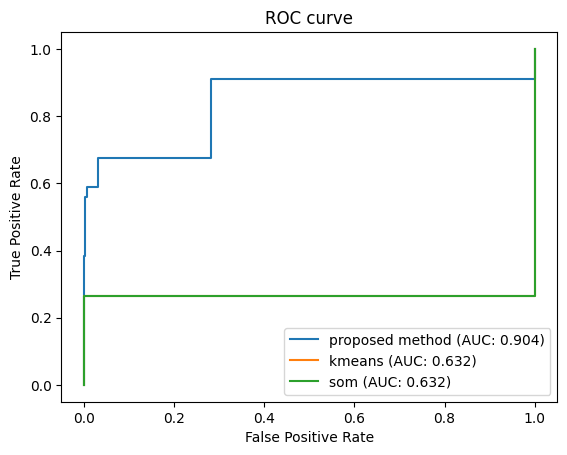

In [11]:
plt.step(ourFPRs, ourTPRs, label=f'proposed method (AUC: {auc(ourFPRs, ourTPRs):.3f})')
plt.step(kmeansFPRs, kmeansTPRs, label=f'kmeans (AUC: {auc(kmeansFPRs, kmeansTPRs):.3f})')
plt.step(somFPRs, somTPRs, label=f'som (AUC: {auc(somFPRs, somTPRs):.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
# plt.show()

plt.savefig(f'roc_interval_{INTERVAL}_src.png')

### 15

In [3]:
INTERVAL = 15

In [4]:
with open(f'timeseries_feature/interval_{INTERVAL}_src_feature/types.json') as f:
    types = json.load(f)
df = pd.read_csv(f'timeseries_feature/interval_{INTERVAL}_src_feature/sorted_rfcm_results.csv', index_col=0, dtype=types)
df = df[["-".join(pair) for pair in itertools.combinations(features, 2)]]

df["avg"] = df.mean(axis=1)
df.sort_values(by="avg", ascending=False, inplace=True)

first_column = df.pop('avg')
df.insert(0, 'avg', first_column)
df.reset_index(inplace=True)

# df[df.ip.isin(filtered)]

In [5]:
kmeans_label = np.load(f'timeseries/interval_{INTERVAL}_src_feature/tslearn_kmeans.npy')
with open(f'timeseries/interval_{INTERVAL}_src_feature/pyts_dataset_sample.txt') as f:
    kmeans_ip = f.read().splitlines()
kmeans_df = pd.DataFrame({'ip': kmeans_ip, 'label': kmeans_label})
# kmeans_df["label"].value_counts()
kmeans_df["label"].replace({key: value for value, key in enumerate(kmeans_df["label"].value_counts().index)}, inplace=True)
kmeans_df.sort_values(by="label", ascending=False, inplace=True)

kmeans_df.reset_index(drop=True, inplace=True)

# kmeans_df[kmeans_df.ip.isin(filtered)]

In [6]:
som_label = np.load(f'timeseries/interval_{INTERVAL}_src_feature/ksom_label.npy')
with open(f'timeseries/interval_{INTERVAL}_src_feature/pyts_dataset_sample.txt') as f:
    ip = f.read().splitlines()
som_df = pd.DataFrame({'ip': ip, 'label': kmeans_label})
# som_df["label"].value_counts()
som_df["label"].replace({key: value for value, key in enumerate(som_df["label"].value_counts().index)}, inplace=True)
som_df.sort_values(by="label", ascending=False, inplace=True)

som_df.reset_index(drop=True, inplace=True)

# som_df[kmeans_df.ip.isin(filtered)]

#### Statistic values of the result

- P = actual positive
- N = actual negative
- PP = predictive positive
- PN = predictive negative
---
- TP = number of PP in P
- FN = number of PN in P
- FP = number of PP in N
- TN = number of PN in N
---
- TPR = TP / P
- FNR = FN / P
- FPR = FP / N
- TNR = TN / N
---
- Prevalence = P / (P + N)
- Accuracy (ACC) = (TP + TN) / (T + N)
---
- Positive Predictive Value (PPV) = TP / PP
- False Discovery Rate (FDR) = FP / PP
- False Omision Rate (FOR) = FN / PN
- Negative Predictive Value (NPV) = TN / PN
---
- Balanced Accuracy (BA) = (TPR + TNR) / 2
- F1-Score = 2TP / (2TP + FP + FN)

In [144]:
thresholds = df[df.ip.isin(filtered)]["avg"].unique().tolist()

for threshold in thresholds:
    print("=" * 20)
    print("Threshold: ", threshold)
    
    P = len(filtered)
    N = len(df) - len(filtered)
    PP = len(df[df["avg"] >= threshold])
    PN = len(df[df["avg"] < threshold])

    TP = len(df[df["avg"] >= threshold][df.ip.isin(filtered)])
    FN = len(df[df["avg"] < threshold][df.ip.isin(filtered)])
    FP = len(df[df["avg"] >= threshold][~df.ip.isin(filtered)])
    TN = len(df[df["avg"] < threshold][~df.ip.isin(filtered)])

    TPR = TP / P
    FNR = FN / P
    FPR = FP / N
    TNR = TN / N

    Prevalence = P / (P + N)
    Accuracy = (TP + TN) / (P + N)

    PPV = TP / PP
    FDR = FP / PP
    FOR = FN / PN
    NPV = TN / PN

    BA = (TPR + TNR) / 2
    F1 = 2 * TP / (2 * TP + FP + FN)
    
    print("-" * 20)
    print("Actual Positive: ", P)
    print("Actual Negative: ", N)
    print("Predicted Positive: ", PP)
    print("Predicted Negative: ", PN)
    print("-" * 20)
    print("True Positive: ", TP)
    print("False Negative: ", FN)
    print("False Positive: ", FP)
    print("True Negative: ", TN)
    print("-" * 20)
    print("True Positive Rate: ", TPR)
    print("False Negative Rate: ", FNR)
    print("False Positive Rate: ", FPR)
    print("True Negative Rate: ", TNR)
    print("-" * 20)
    print("Prevalence: ", Prevalence)
    print("Accuracy: ", Accuracy)
    print("-" * 20)
    print("Positive Predictive Value: ", PPV)
    print("False Discovery Rate: ", FDR)
    print("False Omission Rate: ", FOR)
    print("Negative Predictive Value: ", NPV)
    print("-" * 20)
    print("Balanced Accuracy: ", BA)
    print("F1 Score: ", F1)
    print("=" * 20)
    print()

Threshold:  1.1428571428571428
--------------------
Actual Positive:  1
Actual Negative:  101015
Predicted Positive:  3946
Predicted Negative:  97070
--------------------
True Positive:  1
False Negative:  0
False Positive:  3945
True Negative:  97070
--------------------
True Positive Rate:  1.0
False Negative Rate:  0.0
False Positive Rate:  0.03905360590011384
True Negative Rate:  0.9609463940998861
--------------------
Prevalence:  9.899421873762572e-06
Accuracy:  0.9609467807080067
--------------------
Positive Predictive Value:  0.00025342118601115053
False Discovery Rate:  0.9997465788139889
False Omission Rate:  0.0
Negative Predictive Value:  1.0
--------------------
Balanced Accuracy:  0.9804731970499431
F1 Score:  0.0005067139599695972



In [71]:
thresholds = kmeans_df[kmeans_df.ip.isin(filtered)]["label"].unique().tolist()

for threshold in thresholds:
    print("=" * 20)
    print("Threshold: ", threshold)
    
    P = len(filtered)
    N = len(kmeans_df) - len(filtered)
    PP = len(kmeans_df[kmeans_df["label"] >= threshold])
    PN = len(kmeans_df[kmeans_df["label"] < threshold])

    TP = len(kmeans_df[kmeans_df["label"] >= threshold][kmeans_df.ip.isin(filtered)])
    FN = len(kmeans_df[kmeans_df["label"] < threshold][kmeans_df.ip.isin(filtered)])
    FP = len(kmeans_df[kmeans_df["label"] >= threshold][~kmeans_df.ip.isin(filtered)])
    TN = len(kmeans_df[kmeans_df["label"] < threshold][~kmeans_df.ip.isin(filtered)])

    TPR = TP / P
    FNR = FN / P
    FPR = FP / N
    TNR = TN / N

    Prevalence = P / (P + N)
    Accuracy = (TP + TN) / (P + N)

    PPV = TP / PP
    FDR = FP / PP
    FOR = FN / PN
    NPV = TN / PN

    BA = (TPR + TNR) / 2
    F1 = 2 * TP / (2 * TP + FP + FN)
    
    print("-" * 20)
    print("Actual Positive: ", P)
    print("Actual Negative: ", N)
    print("Predicted Positive: ", PP)
    print("Predicted Negative: ", PN)
    print("-" * 20)
    print("True Positive: ", TP)
    print("False Negative: ", FN)
    print("False Positive: ", FP)
    print("True Negative: ", TN)
    print("-" * 20)
    print("True Positive Rate: ", TPR)
    print("False Negative Rate: ", FNR)
    print("False Positive Rate: ", FPR)
    print("True Negative Rate: ", TNR)
    print("-" * 20)
    print("Prevalence: ", Prevalence)
    print("Accuracy: ", Accuracy)
    print("-" * 20)
    print("Positive Predictive Value: ", PPV)
    print("False Discovery Rate: ", FDR)
    print("False Omission Rate: ", FOR)
    print("Negative Predictive Value: ", NPV)
    print("-" * 20)
    print("Balanced Accuracy: ", BA)
    print("F1 Score: ", F1)
    print("=" * 20)
    print()

Threshold:  9
--------------------
Actual Positive:  31
Actual Negative:  100985
Predicted Positive:  1
Predicted Negative:  101015
--------------------
True Positive:  1
False Negative:  30
False Positive:  0
True Negative:  100985
--------------------
True Positive Rate:  0.03225806451612903
False Negative Rate:  0.967741935483871
False Positive Rate:  0.0
True Negative Rate:  1.0
--------------------
Prevalence:  0.0003068820780866397
Accuracy:  0.9997030173437871
--------------------
Positive Predictive Value:  1.0
False Discovery Rate:  0.0
False Omission Rate:  0.00029698559619858436
Negative Predictive Value:  0.9997030144038014
--------------------
Balanced Accuracy:  0.5161290322580645
F1 Score:  0.0625

Threshold:  8
--------------------
Actual Positive:  31
Actual Negative:  100985
Predicted Positive:  2
Predicted Negative:  101014
--------------------
True Positive:  2
False Negative:  29
False Positive:  0
True Negative:  100985
--------------------
True Positive Rate:  0.

ZeroDivisionError: division by zero

In [ ]:
thresholds = som_df[som_df.ip.isin(filtered)]["label"].unique().tolist()[1:]

for threshold in thresholds:
    print("=" * 20)
    print("Threshold: ", threshold)
    
    P = len(filtered)
    N = len(som_df) - len(filtered)
    PP = len(som_df[som_df["label"] > threshold])
    PN = len(som_df[som_df["label"] <= threshold])

    TP = len(som_df[som_df["label"] > threshold][som_df.ip.isin(filtered)])
    FN = len(som_df[som_df["label"] <= threshold][som_df.ip.isin(filtered)])
    FP = len(som_df[som_df["label"] > threshold][~som_df.ip.isin(filtered)])
    TN = len(som_df[som_df["label"] <= threshold][~som_df.ip.isin(filtered)])

    TPR = TP / P
    FNR = FN / P
    FPR = FP / N
    TNR = TN / N

    Prevalence = P / (P + N)
    Accuracy = (TP + TN) / (P + N)

    PPV = TP / PP
    FDR = FP / PP
    FOR = FN / PN
    NPV = TN / PN

    BA = (TPR + TNR) / 2
    F1 = 2 * TP / (2 * TP + FP + FN)
    
    print("-" * 20)
    print("Actual Positive: ", P)
    print("Actual Negative: ", N)
    print("Predicted Positive: ", PP)
    print("Predicted Negative: ", PN)
    print("-" * 20)
    print("True Positive: ", TP)
    print("False Negative: ", FN)
    print("False Positive: ", FP)
    print("True Negative: ", TN)
    print("-" * 20)
    print("True Positive Rate: ", TPR)
    print("False Negative Rate: ", FNR)
    print("False Positive Rate: ", FPR)
    print("True Negative Rate: ", TNR)
    print("-" * 20)
    print("Prevalence: ", Prevalence)
    print("Accuracy: ", Accuracy)
    print("-" * 20)
    print("Positive Predictive Value: ", PPV)
    print("False Discovery Rate: ", FDR)
    print("False Omission Rate: ", FOR)
    print("Negative Predictive Value: ", NPV)
    print("-" * 20)
    print("Balanced Accuracy: ", BA)
    print("F1 Score: ", F1)
    print("=" * 20)
    print()

Threshold:  8
--------------------
Actual Positive:  13
Actual Negative:  101003
Predicted Positive:  1
Predicted Negative:  101015
--------------------
True Positive:  1
False Negative:  12
False Positive:  0
True Negative:  101003
--------------------
True Positive Rate:  0.07692307692307693
False Negative Rate:  0.9230769230769231
False Positive Rate:  0.0
True Negative Rate:  1.0
--------------------
Prevalence:  0.00012869248435891343
Accuracy:  0.9998812069375148
--------------------
Positive Predictive Value:  1.0
False Discovery Rate:  0.0
False Omission Rate:  0.00011879423847943375
Negative Predictive Value:  0.9998812057615206
--------------------
Balanced Accuracy:  0.5384615384615384
F1 Score:  0.14285714285714285

Threshold:  6
--------------------
Actual Positive:  13
Actual Negative:  101003
Predicted Positive:  3
Predicted Negative:  101013
--------------------
True Positive:  2
False Negative:  11
False Positive:  1
True Negative:  101002
--------------------
True Pos

#### Draw Receiver Operating Characteristic (ROC) curve

In [72]:
thresholds = df[df.ip.isin(filtered)]["avg"].round(2).unique().tolist()
P = len(filtered)
N = len(df) - len(filtered)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(df[df["avg"] > theta])
    PN = len(df[df["avg"] <= theta])
    
    TP = len(df[df["avg"] > theta][df.ip.isin(filtered)])
    FP = len(df[df["avg"] > theta][~df.ip.isin(filtered)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

ourTPRs = list(reversed(TPRs))
ourFPRs = list(reversed(FPRs))
# ourTPRs = TPRs
# ourFPRs = FPRs

In [73]:
thresholds = kmeans_df[kmeans_df.ip.isin(filtered)]["label"].unique().tolist()
P = len(filtered)
N = len(kmeans_df) - len(filtered)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(kmeans_df[kmeans_df["label"] > theta])
    PN = len(kmeans_df[kmeans_df["label"] <= theta])
    
    TP = len(kmeans_df[kmeans_df["label"] > theta][kmeans_df.ip.isin(filtered)])
    FP = len(kmeans_df[kmeans_df["label"] > theta][~kmeans_df.ip.isin(filtered)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

kmeansTPRs = list(reversed(TPRs))
kmeansFPRs = list(reversed(FPRs))
# kmeansTPRs = TPRs
# kmeansFPRs = FPRs

In [74]:
thresholds = som_df[som_df.ip.isin(filtered)]["label"].unique().tolist()
P = len(filtered)
N = len(som_df) - len(filtered)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(som_df[som_df["label"] > theta])
    PN = len(som_df[som_df["label"] <= theta])
    
    TP = len(som_df[som_df["label"] > theta][som_df.ip.isin(filtered)])
    FP = len(som_df[som_df["label"] > theta][~som_df.ip.isin(filtered)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

somTPRs = list(reversed(TPRs))
somFPRs = list(reversed(FPRs))
# somTPRs = TPRs
# somFPRs = FPRs

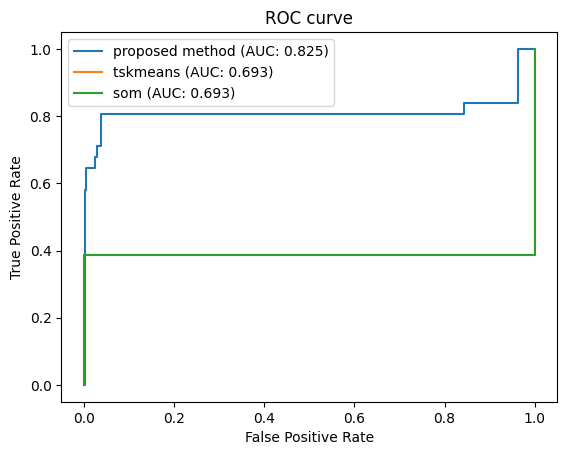

In [75]:
plt.step(ourFPRs, ourTPRs, label=f'proposed method (AUC: {auc(ourFPRs, ourTPRs):.3f})')
plt.step(kmeansFPRs, kmeansTPRs, label=f'tskmeans (AUC: {auc(kmeansFPRs, kmeansTPRs):.3f})')
plt.step(somFPRs, somTPRs, label=f'som (AUC: {auc(somFPRs, somTPRs):.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
# plt.show()

plt.savefig(f'roc_interval_{INTERVAL}_src.png')

### 10

In [21]:
INTERVAL = 10

In [22]:
with open(f'timeseries_feature/interval_{INTERVAL}_src_feature/types.json') as f:
    types = json.load(f)
df = pd.read_csv(f'timeseries_feature/interval_{INTERVAL}_src_feature/sorted_rfcm_results.csv', index_col=0, dtype=types)
df = df[["-".join(pair) for pair in itertools.combinations(features, 2)]]

df["avg"] = df.mean(axis=1)
df.sort_values(by="avg", ascending=False, inplace=True)

first_column = df.pop('avg')
df.insert(0, 'avg', first_column)
df.reset_index(inplace=True)

df[df.ip.isin(anomaly_src)]

,ip,avg,packets-bytes,packets-flows,packets-bytes_packets,packets-flows_(bytes_packets),packets-nDstIP,packets-nSrcPort,packets-nDstPort,bytes-flows,bytes-bytes_packets,bytes-flows_(bytes_packets),bytes-nDstIP,bytes-nSrcPort,bytes-nDstPort,flows-bytes_packets,flows-flows_(bytes_packets),flows-nDstIP,flows-nSrcPort,flows-nDstPort,bytes_packets-flows_(bytes_packets),bytes_packets-nDstIP,bytes_packets-nSrcPort,bytes_packets-nDstPort,flows_(bytes_packets)-nDstIP,flows_(bytes_packets)-nSrcPort,flows_(bytes_packets)-nDstPort,nDstIP-nSrcPort,nDstIP-nDstPort,nSrcPort-nDstPort
45,212.136.37.68,1.928571,1,2,6,2,2,2,2,1,2,1,1,1,1,1,2,2,2,2,6,1,1,1,2,2,2,2,2,2
63,212.136.43.86,1.928571,1,2,6,2,2,2,2,1,2,1,1,1,1,1,2,2,2,2,6,1,1,1,2,2,2,2,2,2
66,212.136.43.87,1.928571,1,2,6,2,2,2,2,1,2,1,1,1,1,1,2,2,2,2,6,1,1,1,2,2,2,2,2,2
80,94.82.58.70,1.928571,1,2,6,2,2,2,2,1,2,1,1,1,1,1,2,2,2,2,6,1,1,1,2,2,2,2,2,2
120,192.205.17.73,1.928571,1,2,6,2,2,2,2,1,2,1,1,1,1,1,2,2,2,2,6,1,1,1,2,2,2,2,2,2
122,88.82.56.168,1.928571,1,2,6,2,2,2,2,1,2,1,1,1,1,1,2,2,2,2,6,1,1,1,2,2,2,2,2,2
155,171.148.229.203,1.928571,1,2,6,2,2,2,2,1,2,1,1,1,1,1,2,2,2,2,6,1,1,1,2,2,2,2,2,2
160,212.136.45.198,1.928571,1,2,6,2,2,2,2,1,2,1,1,1,1,1,2,2,2,2,6,1,1,1,2,2,2,2,2,2
163,212.205.124.182,1.928571,1,2,6,2,2,2,2,1,2,1,1,1,1,1,2,2,2,2,6,1,1,1,2,2,2,2,2,2
168,171.26.178.147,1.928571,1,2,6,2,2,2,2,1,2,1,1,1,1,1,2,2,2,2,6,1,1,1,2,2,2,2,2,2


In [23]:
kmeans_label = np.load(f'timeseries/interval_{INTERVAL}_src_feature/tslearn_kmeans.npy')
with open(f'timeseries/interval_{INTERVAL}_src_feature/pyts_dataset_sample.txt') as f:
    kmeans_ip = f.read().splitlines()
kmeans_df = pd.DataFrame({'ip': kmeans_ip, 'label': kmeans_label})
# kmeans_df["label"].value_counts()
kmeans_df["label"].replace({key: value for value, key in enumerate(kmeans_df["label"].value_counts().index)}, inplace=True)
kmeans_df.sort_values(by="label", ascending=False, inplace=True)

kmeans_df.reset_index(drop=True, inplace=True)

kmeans_df[kmeans_df.ip.isin(anomaly_src)]

,ip,label
0,212.136.45.198,9
1,212.136.37.68,8
3,187.168.11.99,6
4,171.148.229.203,5
5,171.26.178.147,4
12,212.136.43.87,2
16,212.136.43.86,2
31,213.139.30.85,1
110,219.184.185.217,1
115,94.82.58.70,1


In [24]:
som_label = np.load(f'timeseries/interval_{INTERVAL}_src_feature/ksom_label.npy')
with open(f'timeseries/interval_{INTERVAL}_src_feature/pyts_dataset_sample.txt') as f:
    ip = f.read().splitlines()
som_df = pd.DataFrame({'ip': ip, 'label': kmeans_label})
# som_df["label"].value_counts()
som_df["label"].replace({key: value for value, key in enumerate(som_df["label"].value_counts().index)}, inplace=True)
som_df.sort_values(by="label", ascending=False, inplace=True)

som_df.reset_index(drop=True, inplace=True)

som_df[kmeans_df.ip.isin(anomaly_src)]

,ip,label
0,212.136.45.198,9
1,212.136.37.68,8
3,187.168.11.99,6
4,171.148.229.203,5
5,171.26.178.147,4
12,212.136.43.87,2
16,212.136.43.86,2
31,213.139.30.85,1
110,219.184.185.217,1
115,94.82.58.70,1


#### Statistic values of the result

- P = actual positive
- N = actual negative
- PP = predictive positive
- PN = predictive negative
---
- TP = number of PP in P
- FN = number of PN in P
- FP = number of PP in N
- TN = number of PN in N
---
- TPR = TP / P
- FNR = FN / P
- FPR = FP / N
- TNR = TN / N
---
- Prevalence = P / (P + N)
- Accuracy (ACC) = (TP + TN) / (T + N)
---
- Positive Predictive Value (PPV) = TP / PP
- False Discovery Rate (FDR) = FP / PP
- False Omision Rate (FOR) = FN / PN
- Negative Predictive Value (NPV) = TN / PN
---
- Balanced Accuracy (BA) = (TPR + TNR) / 2
- F1-Score = 2TP / (2TP + FP + FN)

In [25]:
thresholds = df[df.ip.isin(anomaly_src)]["avg"].round(2).unique().tolist()

for threshold in thresholds:
    print("=" * 20)
    print("Threshold: ", threshold)
    
    P = len(anomaly_src)
    N = len(df) - len(anomaly_src)
    PP = len(df[df["avg"] > threshold])
    PN = len(df[df["avg"] <= threshold])

    TP = len(df[df["avg"] > threshold][df.ip.isin(anomaly_src)])
    FN = len(df[df["avg"] <= threshold][df.ip.isin(anomaly_src)])
    FP = len(df[df["avg"] > threshold][~df.ip.isin(anomaly_src)])
    TN = len(df[df["avg"] <= threshold][~df.ip.isin(anomaly_src)])

    TPR = TP / P
    FNR = FN / P
    FPR = FP / N
    TNR = TN / N

    Prevalence = P / (P + N)
    Accuracy = (TP + TN) / (P + N)

    PPV = TP / PP
    FDR = FP / PP
    FOR = FN / PN
    NPV = TN / PN

    BA = (TPR + TNR) / 2
    F1 = 2 * TP / (2 * TP + FP + FN)
    
    print("-" * 20)
    print("Actual Positive: ", P)
    print("Actual Negative: ", N)
    print("Predicted Positive: ", PP)
    print("Predicted Negative: ", PN)
    print("-" * 20)
    print("True Positive: ", TP)
    print("False Negative: ", FN)
    print("False Positive: ", FP)
    print("True Negative: ", TN)
    print("-" * 20)
    print("True Positive Rate: ", TPR)
    print("False Negative Rate: ", FNR)
    print("False Positive Rate: ", FPR)
    print("True Negative Rate: ", TNR)
    print("-" * 20)
    print("Prevalence: ", Prevalence)
    print("Accuracy: ", Accuracy)
    print("-" * 20)
    print("Positive Predictive Value: ", PPV)
    print("False Discovery Rate: ", FDR)
    print("False Omission Rate: ", FOR)
    print("Negative Predictive Value: ", NPV)
    print("-" * 20)
    print("Balanced Accuracy: ", BA)
    print("F1 Score: ", F1)
    print("=" * 20)

Threshold:  1.93
--------------------
Actual Positive:  34
Actual Negative:  100982
Predicted Positive:  37
Predicted Negative:  100979
--------------------
True Positive:  0
False Negative:  31
False Positive:  37
True Negative:  100948
--------------------
True Positive Rate:  0.0
False Negative Rate:  0.9117647058823529
False Positive Rate:  0.00036640193301776556
True Negative Rate:  0.9996633063318215
--------------------
Prevalence:  0.00033658034370792747
Accuracy:  0.9993268393125841
--------------------
Positive Predictive Value:  0.0
False Discovery Rate:  1.0
False Omission Rate:  0.0003069945236138207
Negative Predictive Value:  0.9996930054763862
--------------------
Balanced Accuracy:  0.49983165316591077
F1 Score:  0.0
Threshold:  1.82
--------------------
Actual Positive:  34
Actual Negative:  100982
Predicted Positive:  431
Predicted Negative:  100585
--------------------
True Positive:  13
False Negative:  18
False Positive:  418
True Negative:  100567
---------------

#### Draw Receiver Operating Characteristic (ROC) curve

In [26]:
thresholds = df[df.ip.isin(anomaly_src)]["avg"].round(2).unique().tolist()
P = len(anomaly_src)
N = len(df) - len(anomaly_src)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(df[df["avg"] > theta])
    PN = len(df[df["avg"] <= theta])
    
    TP = len(df[df["avg"] > theta][df.ip.isin(anomaly_src)])
    FP = len(df[df["avg"] > theta][~df.ip.isin(anomaly_src)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

ourTPRs = list(reversed(TPRs))
ourFPRs = list(reversed(FPRs))
# ourTPRs = TPRs
# ourFPRs = FPRs

In [27]:
thresholds = kmeans_df[kmeans_df.ip.isin(anomaly_src)]["label"].unique().tolist()
P = len(anomaly_src)
N = len(kmeans_df) - len(anomaly_src)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(kmeans_df[kmeans_df["label"] > theta])
    PN = len(kmeans_df[kmeans_df["label"] <= theta])
    
    TP = len(kmeans_df[kmeans_df["label"] > theta][kmeans_df.ip.isin(anomaly_src)])
    FP = len(kmeans_df[kmeans_df["label"] > theta][~kmeans_df.ip.isin(anomaly_src)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

kmeansTPRs = list(reversed(TPRs))
kmeansFPRs = list(reversed(FPRs))
# kmeansTPRs = TPRs
# kmeansFPRs = FPRs

In [28]:
thresholds = som_df[som_df.ip.isin(anomaly_src)]["label"].unique().tolist()
P = len(anomaly_src)
N = len(som_df) - len(anomaly_src)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(som_df[som_df["label"] > theta])
    PN = len(som_df[som_df["label"] <= theta])
    
    TP = len(som_df[som_df["label"] > theta][som_df.ip.isin(anomaly_src)])
    FP = len(som_df[som_df["label"] > theta][~som_df.ip.isin(anomaly_src)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

somTPRs = list(reversed(TPRs))
somFPRs = list(reversed(FPRs))
# somTPRs = TPRs
# somFPRs = FPRs

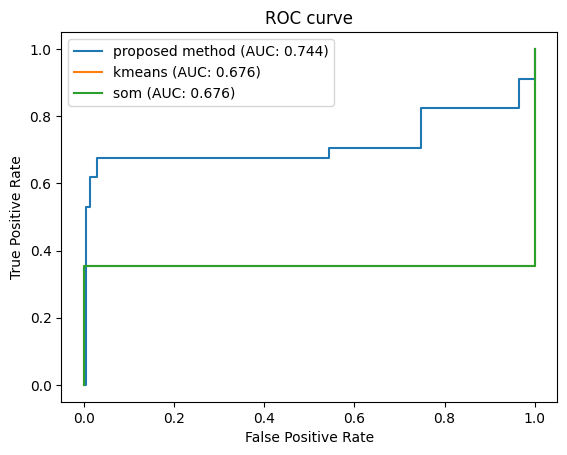

In [29]:
plt.step(ourFPRs, ourTPRs, label=f'proposed method (AUC: {auc(ourFPRs, ourTPRs):.3f})')
plt.step(kmeansFPRs, kmeansTPRs, label=f'kmeans (AUC: {auc(kmeansFPRs, kmeansTPRs):.3f})')
plt.step(somFPRs, somTPRs, label=f'som (AUC: {auc(somFPRs, somTPRs):.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
# plt.show()

plt.savefig(f'roc_interval_{INTERVAL}_src.png')

### 5

In [30]:
INTERVAL = 5

In [31]:
with open(f'timeseries_feature/interval_{INTERVAL}_src_feature/types.json') as f:
    types = json.load(f)
df = pd.read_csv(f'timeseries_feature/interval_{INTERVAL}_src_feature/sorted_rfcm_results.csv', index_col=0, dtype=types)
df = df[["-".join(pair) for pair in itertools.combinations(features, 2)]]

df["avg"] = df.mean(axis=1)
df.sort_values(by="avg", ascending=False, inplace=True)

first_column = df.pop('avg')
df.insert(0, 'avg', first_column)
df.reset_index(inplace=True)

df[df.ip.isin(anomaly_src)]

,ip,avg,packets-bytes,packets-flows,packets-bytes_packets,packets-flows_(bytes_packets),packets-nDstIP,packets-nSrcPort,packets-nDstPort,bytes-flows,bytes-bytes_packets,bytes-flows_(bytes_packets),bytes-nDstIP,bytes-nSrcPort,bytes-nDstPort,flows-bytes_packets,flows-flows_(bytes_packets),flows-nDstIP,flows-nSrcPort,flows-nDstPort,bytes_packets-flows_(bytes_packets),bytes_packets-nDstIP,bytes_packets-nSrcPort,bytes_packets-nDstPort,flows_(bytes_packets)-nDstIP,flows_(bytes_packets)-nSrcPort,flows_(bytes_packets)-nDstPort,nDstIP-nSrcPort,nDstIP-nDstPort,nSrcPort-nDstPort
6,204.195.4.72,2.428571,3,2,2,2,2,2,2,3,2,2,3,3,3,4,2,2,2,2,1,4,4,4,2,2,2,2,2,2
14,212.136.45.198,2.392857,3,2,2,2,2,2,2,3,2,2,3,3,3,4,2,2,2,2,0,4,4,4,2,2,2,2,2,2
18,212.136.43.87,2.392857,3,2,2,2,2,2,2,3,2,2,3,3,3,4,2,2,2,2,0,4,4,4,2,2,2,2,2,2
20,212.136.43.86,2.392857,3,2,2,2,2,2,2,3,2,2,3,3,3,4,2,2,2,2,0,4,4,4,2,2,2,2,2,2
49,171.26.178.147,2.392857,3,2,2,2,2,2,2,3,2,2,3,3,3,4,2,2,2,2,0,4,4,4,2,2,2,2,2,2
56,196.135.158.151,2.392857,3,2,2,2,2,2,2,3,2,2,3,3,3,4,2,2,2,2,0,4,4,4,2,2,2,2,2,2
82,88.82.56.168,2.392857,3,2,2,2,2,2,2,3,2,2,3,3,3,4,2,2,2,2,0,4,4,4,2,2,2,2,2,2
108,212.136.37.68,2.392857,3,2,2,2,2,2,2,3,2,2,3,3,3,4,2,2,2,2,0,4,4,4,2,2,2,2,2,2
113,172.36.161.123,2.392857,3,2,2,2,2,2,2,3,2,2,3,3,3,4,2,2,2,2,0,4,4,4,2,2,2,2,2,2
116,202.64.138.203,2.392857,3,2,2,2,2,2,2,3,2,2,3,3,3,4,2,2,2,2,0,4,4,4,2,2,2,2,2,2


In [32]:
kmeans_label = np.load(f'timeseries/interval_{INTERVAL}_src_feature/tslearn_kmeans.npy')
with open(f'timeseries/interval_{INTERVAL}_src_feature/pyts_dataset_sample.txt') as f:
    kmeans_ip = f.read().splitlines()
kmeans_df = pd.DataFrame({'ip': kmeans_ip, 'label': kmeans_label})
# kmeans_df["label"].value_counts()
kmeans_df["label"].replace({key: value for value, key in enumerate(kmeans_df["label"].value_counts().index)}, inplace=True)
kmeans_df.sort_values(by="label", ascending=False, inplace=True)

kmeans_df.reset_index(drop=True, inplace=True)

kmeans_df[kmeans_df.ip.isin(anomaly_src)]

,ip,label
0,212.136.45.198,9
1,212.136.37.68,8
3,187.168.11.99,6
4,171.148.229.203,5
6,212.136.43.86,4
10,171.26.178.147,2
16,212.205.124.182,1
86,212.136.43.87,1
87,213.139.30.85,1
98,94.82.58.70,1


In [33]:
som_label = np.load(f'timeseries/interval_{INTERVAL}_src_feature/ksom_label.npy')
with open(f'timeseries/interval_{INTERVAL}_src_feature/pyts_dataset_sample.txt') as f:
    ip = f.read().splitlines()
som_df = pd.DataFrame({'ip': ip, 'label': kmeans_label})
# som_df["label"].value_counts()
som_df["label"].replace({key: value for value, key in enumerate(som_df["label"].value_counts().index)}, inplace=True)
som_df.sort_values(by="label", ascending=False, inplace=True)

som_df.reset_index(drop=True, inplace=True)

som_df[kmeans_df.ip.isin(anomaly_src)]

,ip,label
0,212.136.45.198,9
1,212.136.37.68,8
3,187.168.11.99,6
4,171.148.229.203,5
6,212.136.43.86,4
10,171.26.178.147,2
16,212.205.124.182,1
86,212.136.43.87,1
87,213.139.30.85,1
98,94.82.58.70,1


#### Statistic values of the result

- P = actual positive
- N = actual negative
- PP = predictive positive
- PN = predictive negative
---
- TP = number of PP in P
- FN = number of PN in P
- FP = number of PP in N
- TN = number of PN in N
---
- TPR = TP / P
- FNR = FN / P
- FPR = FP / N
- TNR = TN / N
---
- Prevalence = P / (P + N)
- Accuracy (ACC) = (TP + TN) / (T + N)
---
- Positive Predictive Value (PPV) = TP / PP
- False Discovery Rate (FDR) = FP / PP
- False Omision Rate (FOR) = FN / PN
- Negative Predictive Value (NPV) = TN / PN
---
- Balanced Accuracy (BA) = (TPR + TNR) / 2
- F1-Score = 2TP / (2TP + FP + FN)

In [34]:
thresholds = df[df.ip.isin(anomaly_src)]["avg"].round(2).unique().tolist()

for threshold in thresholds:
    print("=" * 20)
    print("Threshold: ", threshold)
    
    P = len(anomaly_src)
    N = len(df) - len(anomaly_src)
    PP = len(df[df["avg"] > threshold])
    PN = len(df[df["avg"] <= threshold])

    TP = len(df[df["avg"] > threshold][df.ip.isin(anomaly_src)])
    FN = len(df[df["avg"] <= threshold][df.ip.isin(anomaly_src)])
    FP = len(df[df["avg"] > threshold][~df.ip.isin(anomaly_src)])
    TN = len(df[df["avg"] <= threshold][~df.ip.isin(anomaly_src)])

    TPR = TP / P
    FNR = FN / P
    FPR = FP / N
    TNR = TN / N

    Prevalence = P / (P + N)
    Accuracy = (TP + TN) / (P + N)

    PPV = TP / PP
    FDR = FP / PP
    FOR = FN / PN
    NPV = TN / PN

    BA = (TPR + TNR) / 2
    F1 = 2 * TP / (2 * TP + FP + FN)
    
    print("-" * 20)
    print("Actual Positive: ", P)
    print("Actual Negative: ", N)
    print("Predicted Positive: ", PP)
    print("Predicted Negative: ", PN)
    print("-" * 20)
    print("True Positive: ", TP)
    print("False Negative: ", FN)
    print("False Positive: ", FP)
    print("True Negative: ", TN)
    print("-" * 20)
    print("True Positive Rate: ", TPR)
    print("False Negative Rate: ", FNR)
    print("False Positive Rate: ", FPR)
    print("True Negative Rate: ", TNR)
    print("-" * 20)
    print("Prevalence: ", Prevalence)
    print("Accuracy: ", Accuracy)
    print("-" * 20)
    print("Positive Predictive Value: ", PPV)
    print("False Discovery Rate: ", FDR)
    print("False Omission Rate: ", FOR)
    print("Negative Predictive Value: ", NPV)
    print("-" * 20)
    print("Balanced Accuracy: ", BA)
    print("F1 Score: ", F1)
    print("=" * 20)

Threshold:  2.43
--------------------
Actual Positive:  34
Actual Negative:  100982
Predicted Positive:  4
Predicted Negative:  101012
--------------------
True Positive:  0
False Negative:  31
False Positive:  4
True Negative:  100981
--------------------
True Positive Rate:  0.0
False Negative Rate:  0.9117647058823529
False Positive Rate:  3.961101978570438e-05
True Negative Rate:  0.9999900972450536
--------------------
Prevalence:  0.00033658034370792747
Accuracy:  0.9996535202344183
--------------------
Positive Predictive Value:  0.0
False Discovery Rate:  1.0
False Omission Rate:  0.0003068942303884687
Negative Predictive Value:  0.9996931057696116
--------------------
Balanced Accuracy:  0.4999950486225268
F1 Score:  0.0
Threshold:  2.39
--------------------
Actual Positive:  34
Actual Negative:  100982
Predicted Positive:  337
Predicted Negative:  100679
--------------------
True Positive:  18
False Negative:  13
False Positive:  319
True Negative:  100666
-------------------

#### Draw Receiver Operating Characteristic (ROC) curve

In [35]:
thresholds = df[df.ip.isin(anomaly_src)]["avg"].round(2).unique().tolist()
P = len(anomaly_src)
N = len(df) - len(anomaly_src)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(df[df["avg"] > theta])
    PN = len(df[df["avg"] <= theta])
    
    TP = len(df[df["avg"] > theta][df.ip.isin(anomaly_src)])
    FP = len(df[df["avg"] > theta][~df.ip.isin(anomaly_src)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

ourTPRs = list(reversed(TPRs))
ourFPRs = list(reversed(FPRs))
# ourTPRs = TPRs
# ourFPRs = FPRs

In [36]:
thresholds = kmeans_df[kmeans_df.ip.isin(anomaly_src)]["label"].unique().tolist()
P = len(anomaly_src)
N = len(kmeans_df) - len(anomaly_src)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(kmeans_df[kmeans_df["label"] > theta])
    PN = len(kmeans_df[kmeans_df["label"] <= theta])
    
    TP = len(kmeans_df[kmeans_df["label"] > theta][kmeans_df.ip.isin(anomaly_src)])
    FP = len(kmeans_df[kmeans_df["label"] > theta][~kmeans_df.ip.isin(anomaly_src)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

kmeansTPRs = list(reversed(TPRs))
kmeansFPRs = list(reversed(FPRs))
# kmeansTPRs = TPRs
# kmeansFPRs = FPRs

In [37]:
thresholds = som_df[som_df.ip.isin(anomaly_src)]["label"].unique().tolist()
P = len(anomaly_src)
N = len(som_df) - len(anomaly_src)

# Prepare for ROC curve
TPRs = []
FPRs = []
for theta in thresholds:
    PP = len(som_df[som_df["label"] > theta])
    PN = len(som_df[som_df["label"] <= theta])
    
    TP = len(som_df[som_df["label"] > theta][som_df.ip.isin(anomaly_src)])
    FP = len(som_df[som_df["label"] > theta][~som_df.ip.isin(anomaly_src)])
    
    TPRs.append(TP / P)
    FPRs.append(FP / N)
    
TPRs = [0] + TPRs + [1]
FPRs = [0] + FPRs + [1]

somTPRs = list(reversed(TPRs))
somFPRs = list(reversed(FPRs))
# somTPRs = TPRs
# somFPRs = FPRs

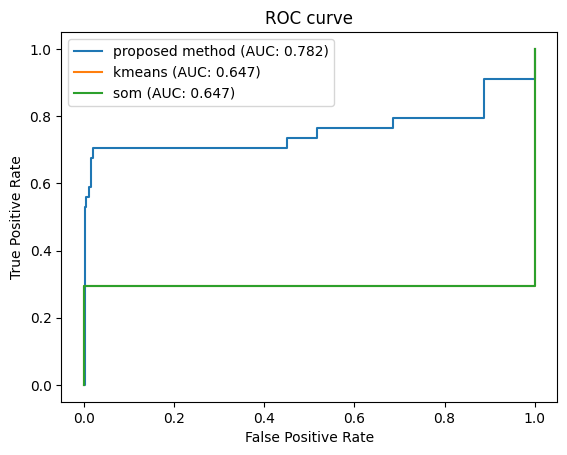

In [38]:
plt.step(ourFPRs, ourTPRs, label=f'proposed method (AUC: {auc(ourFPRs, ourTPRs):.3f})')
plt.step(kmeansFPRs, kmeansTPRs, label=f'kmeans (AUC: {auc(kmeansFPRs, kmeansTPRs):.3f})')
plt.step(somFPRs, somTPRs, label=f'som (AUC: {auc(somFPRs, somTPRs):.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
# plt.show()

plt.savefig(f'roc_interval_{INTERVAL}_src.png')